In [1]:
# System.
import glob
import os
import random

# Data.
import pandas as pd
import matplotlib.pylab as plt

# Numeric.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset
from torch_geometric.data.data import Data
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv, global_max_pool, TopKPooling

In [2]:
# Load in dataframe for some information.
traindf = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/LSTM/TRAIN_SCALED.csv')
valdf = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/LSTM/VAL_SCALED.csv')
testdf = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/LSTM/TEST_SCALED.csv')

traindf.drop(['County Name', 'State', 'countyFIPS', 'Unnamed: 0'], axis=1, inplace=True)
valdf.drop(['County Name', 'State', 'countyFIPS', 'Unnamed: 0'], axis=1, inplace=True)
testdf.drop(['County Name', 'State', 'countyFIPS', 'Unnamed: 0'], axis=1, inplace=True)

dates = list(traindf.columns) + list(valdf.columns) + list(testdf.columns) 
train_dates = list(traindf.columns)
val_dates = list(valdf.columns)
test_dates = list(testdf.columns)
date_to_idx = {date: i for i, date in enumerate(dates)}

In [3]:
t1 = '/Users/jakecordery/Desktop/dissertation-york/data/processed/GCN/val_graphs'
t2 = '/Users/jakecordery/Desktop/dissertation-york/data/processed/GCN/test_graphs'
def remove_nan_graphs(t):
    for p in glob.glob(os.path.join(t, '*pt')):
        ten = torch.load(p, weights_only=False)
        if any(torch.isnan(ten.x).flatten()):
            print(f"{p} has nan values.\nRemoving {p}...")
            os.remove(p)
remove_nan_graphs(t1)
remove_nan_graphs(t2)

In [4]:
class CFG:
    device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class GraphDataset(Dataset):
    def __init__(self, path, window_size, dates, date_to_idx=date_to_idx):
        self.paths = glob.glob(os.path.join(path, "*pt"))
        self.N = [int(p[-5:-3]) for p in self.paths]
        self.graphs = {
            f"{n:02d}": torch.load(p, weights_only=False, map_location=CFG.device) 
            for p, n in zip(self.paths, self.N)
            }
        self.in_window_size = window_size-7
        self.lab_window_size = 7
        #self.start_date = date_to_idx[dates[0]]
        self.num_dates = len(dates)
        self.valid_start_dates = self.num_dates - 36 #self.start_date + self.num_dates - 36
        self.num_states = 50

    
    def __len__(self):
        return int((self.num_states - 10) * self.valid_start_dates) # Random subset of the states.
    
    def select_window(self, H, idx1, idx2):
        H_window = H.clone()
        H_window.x = H.x[:, idx1:idx2]
        return H_window
    
    def __getitem__(self, idx):
        data = {}
        # Randomly select a state (and therefore a graph).
        state_idx = random.randint(0, len(self.N)-1)
        state_key = f"{self.N[state_idx]:02d}"
        H = self.graphs[state_key]

        # Randomly choose a time window and edit the data in the graphs.
        window_start = random.randint(0, self.valid_start_dates - 1)
        input_graph = self.select_window(H, idx1=window_start, idx2=window_start+self.in_window_size)
        label_graph = self.select_window(H, idx1=window_start+self.in_window_size,
                                         idx2=window_start+self.in_window_size+self.lab_window_size)
        # Create a new Data object with input graph data and attach the label as the y attribute.
        # Assume that input_graph has attributes like x, edge_index, pos, etc.
        data = Data(x=input_graph.x.float(),
                    edge_index=input_graph.edge_index,
                    pos=input_graph.pos.float(),
                    y=label_graph.x.float(),
                    window_start=window_start, # For animation.
                    state_key=state_key # For animation.
                    )
        
        if data.x.shape[-1] != self.in_window_size or data.y.shape[-1] != self.lab_window_size:
            #print('recursed')
            return self.__getitem__(idx)

        return data 

In [6]:
vds = GraphDataset('/Users/jakecordery/Desktop/dissertation-york/data/processed/GCN/val_graphs', dates=val_dates, window_size=35)
vds[0].x

tensor([[0.7813, 0.6903, 0.6277,  ..., 0.2344, 0.2250, 0.2221],
        [0.6130, 0.4704, 0.4576,  ..., 0.1308, 0.1144, 0.1206],
        [0.6393, 0.5811, 0.5108,  ..., 0.1322, 0.1177, 0.1291],
        ...,
        [0.7028, 0.4626, 0.4659,  ..., 0.1202, 0.0708, 0.1248],
        [0.6270, 0.3991, 0.2777,  ..., 0.1818, 0.1473, 0.1985],
        [0.5623, 0.4374, 0.3873,  ..., 0.1137, 0.0986, 0.0916]])

In [7]:
class GCN1(nn.Module):
    def __init__(self, in_size, hidden):
        super(GCN1, self).__init__()
        
        self.conv1 = GCNConv(in_channels=in_size,
                              out_channels=hidden) 
        self.conv2 = GCNConv(in_channels=hidden,
                             out_channels=7)
        self.fc = nn.Linear(7, 7)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(F.relu(self.conv1(x, edge_index)), training=self.training)
        x = F.dropout(F.relu(self.conv2(x, edge_index)), training=self.training)
        x = self.fc(x)

        return x

In [8]:
class GCN2(nn.Module):
    def __init__(self, hidden1, hidden2):
        super(GCN2, self).__init__()
        
        self.conv1 = GCNConv(in_channels=28,
                              out_channels=hidden1) 
        self.conv2 = GCNConv(in_channels=hidden1,
                             out_channels=hidden2)
        self.conv3 = GCNConv(in_channels=hidden2,
                             out_channels=7) 
        self.fc = nn.Linear(7, 7)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(F.relu(self.conv1(x, edge_index)), training=self.training)
        x = F.dropout(F.relu(self.conv2(x, edge_index)), training=self.training)
        x = F.dropout(F.relu(self.conv3(x, edge_index)), training=self.training)
        x = self.fc(x)

        return x

In [9]:
def display_preds(pred, label, loss):
    # A function that plots the loss of one sample (the one week of label).
    plt.figure()
    actual = plt.plot(torch.arange(1, label.shape[0]+1), label, 'b', label='Actual Cases') # Normalised scale, but unnormalised error.
    pred = plt.plot(torch.arange(1, pred.shape[0]+1), pred, 'r', label='Predicted Cases')
    #plt.axis([1, 7, -4, 4])
    plt.xlabel('Day 21-28')
    plt.ylabel('Normalized Cases')
    plt.title(f'Loss: {loss}')
    plt.legend()
    plt.show()

In [10]:
def test(model, dataset, bs, showres=True):
    model.eval()
    tot_loss = 0
    with torch.amp.autocast('cpu'):
        with torch.no_grad():
            for i in range(1, len(dataset)//bs):
                data_slice = Subset(dataset, range(i*bs, (i+1)*bs))
                #print(data_slice[0])

                batch = Batch.from_data_list(data_slice).to(CFG.device)
                label = batch.y

                output = model(batch) # Output shape is (bs, num_counties, 7).

                loss = F.mse_loss(output, label)
                tot_loss += loss.item()

    #print(tot_loss)
    avloss = tot_loss/(len(dataset)//bs)
    print(f"Average test loss: {avloss}")
    # if showres:
    #     output = output.detach().numpy()
    #     label = label.detach().numpy()
    #     display_preds(np.mean(output, axis=0).flatten(), np.mean(label, axis=0).flatten(), loss=loss.item())
    return avloss

In [11]:
from lstm_helper_fns import plot_accs

def train(model, optimizer, dataset, valds, testds, bs, spath, val=True):
    os.makedirs(spath, exist_ok=True)
    train_losses = np.array([])
    val_losses = np.array([])
    test_losses = np.array([])

    for epoch in range(35+1):
        model.train()
        tot_loss = 0
        with torch.amp.autocast('cpu'):
            for i in range(1, len(dataset)//bs):
                data_slice = Subset(dataset, range(i*bs, (i+1)*bs))
                batch = Batch.from_data_list(data_slice).to(CFG.device)
                label = batch.y

                if batch.x.shape[1] == 0:
                    print(batch.x.shape)
                    continue

                optimizer.zero_grad()
                output = model(batch) # Output shape is (bs, num_counties, 7).
                    
                # Backpropagation.
                loss = F.mse_loss(output, label)
                loss.backward()
                optimizer.step()
                tot_loss += loss.item()

            av_train_loss = tot_loss/(len(dataset)//bs)
            print(f"Average loss epoch {epoch}: {av_train_loss}")
            train_losses = np.append(train_losses, av_train_loss)
            
        p = os.path.join(spath, f"gE{epoch:02d}.pth")
        torch.save(model, p)
        if val: # Validate the model results - show a sample.
            av_val_acc = test(model, valds, bs)
            av_test_acc = test(model, testds, bs)
            val_losses = np.append(val_losses, av_val_acc)
            test_losses = np.append(test_losses, av_test_acc)
            #plot_accs(train_losses, val_losses)
            plot_accs(train_losses, val_losses, test_losses)
        else:
            plot_accs(train_losses)

Training model: w:42, h:128
23840 1880 3600
Average loss epoch 0: 0.22885411665324243
Average test loss: 0.35983069241046906
Average test loss: 0.5427085012197495


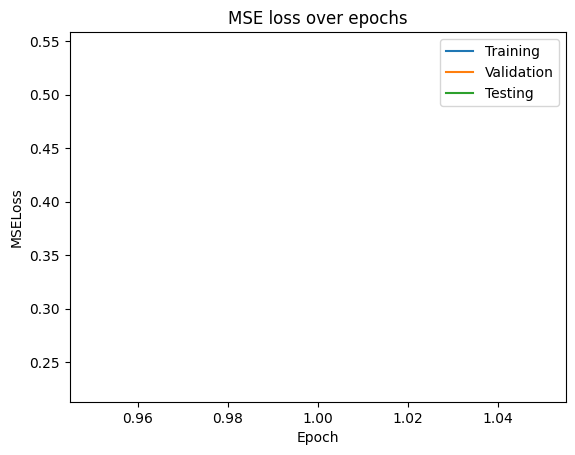

Average loss epoch 1: 0.19899932647584587
Average test loss: 0.3324844241142273
Average test loss: 0.4971004309398787


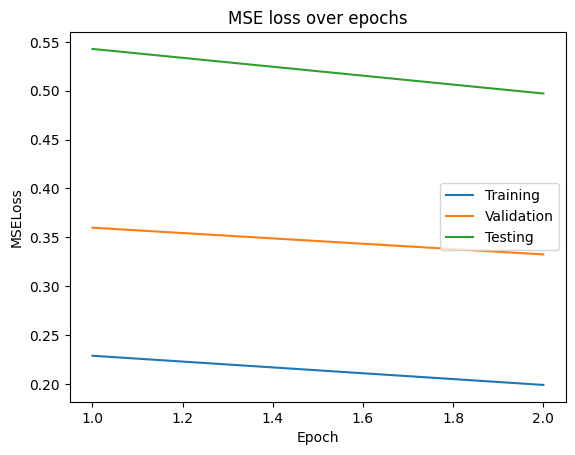

Average loss epoch 2: 0.18349225266325858
Average test loss: 0.3031547452722277
Average test loss: 0.44715737445013864


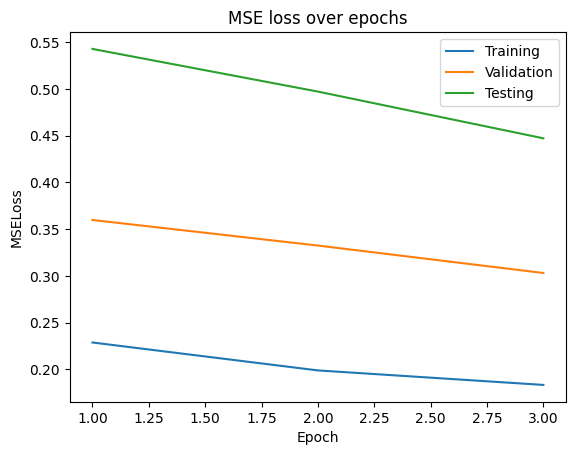

Average loss epoch 3: 0.17244856452108712
Average test loss: 0.27101812192371916
Average test loss: 0.3932974157588823


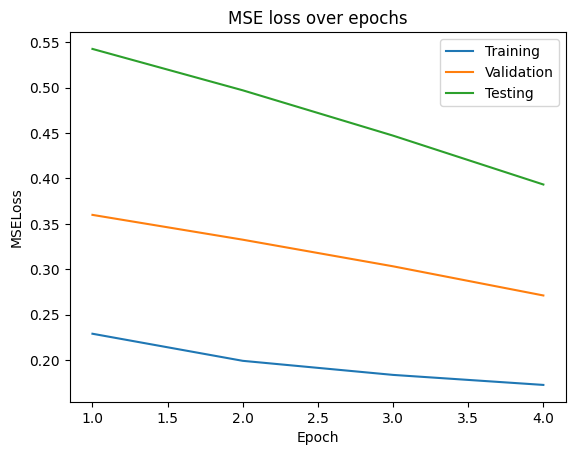

Average loss epoch 4: 0.16089121100082193
Average test loss: 0.24879737836974009
Average test loss: 0.3450088990586145


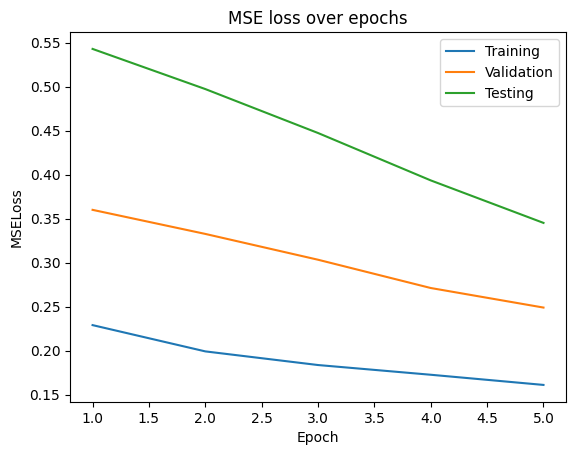

Average loss epoch 5: 0.15380769142861006
Average test loss: 0.2308117151260376
Average test loss: 0.312433911221368


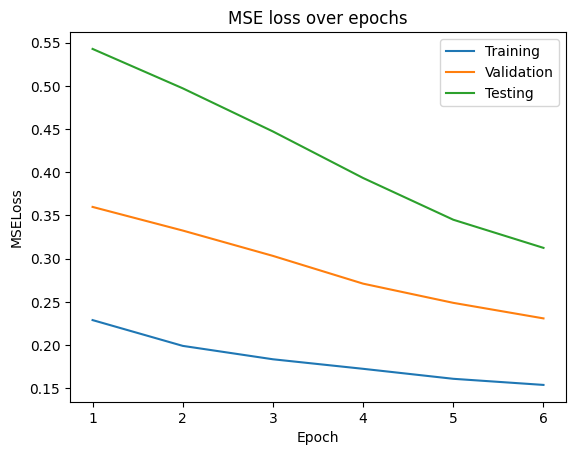

Average loss epoch 6: 0.14943364254569494
Average test loss: 0.22050060012510844
Average test loss: 0.30703306198120117


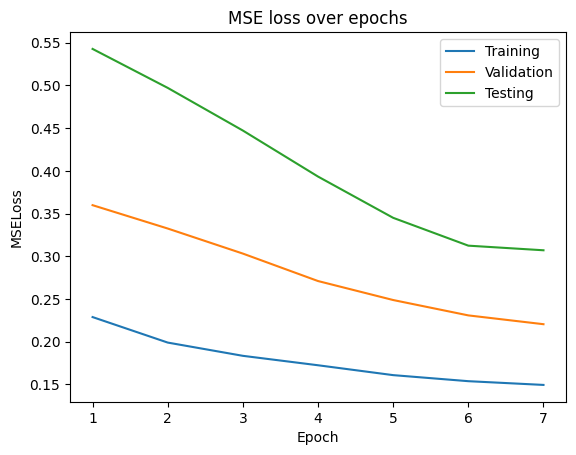

Average loss epoch 7: 0.14747647732816715
Average test loss: 0.21187463722058705
Average test loss: 0.302199801164014


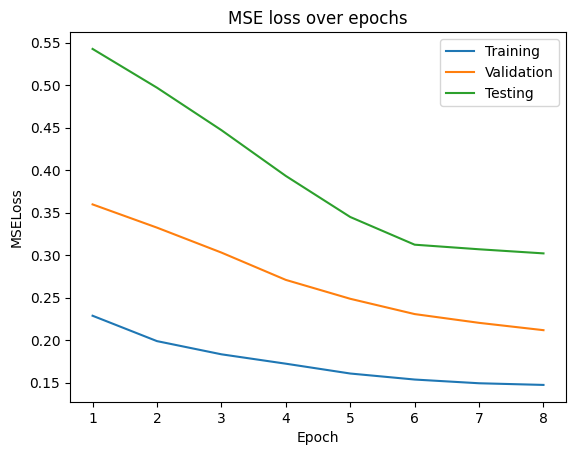

Average loss epoch 8: 0.144521555192368
Average test loss: 0.21172726260764257
Average test loss: 0.2943096746291433


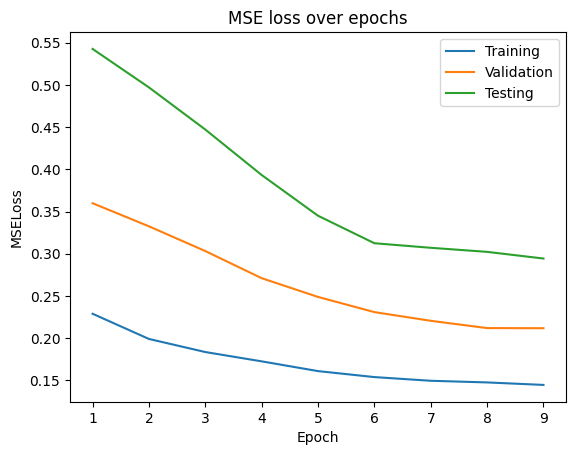

Average loss epoch 9: 0.14278981954820694
Average test loss: 0.20428409746715
Average test loss: 0.28054758587053846


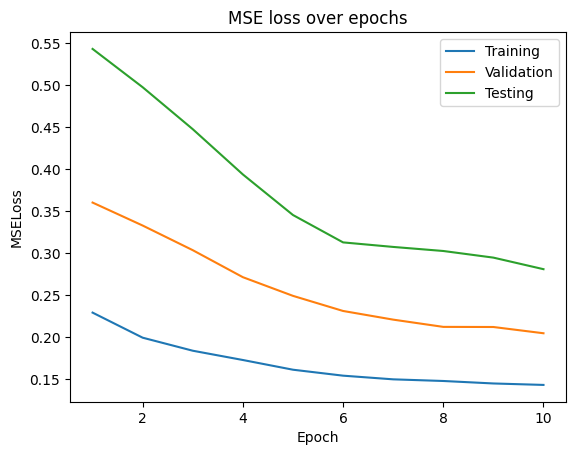

Average loss epoch 10: 0.139832174785996
Average test loss: 0.21102589581693923
Average test loss: 0.29178105507578167


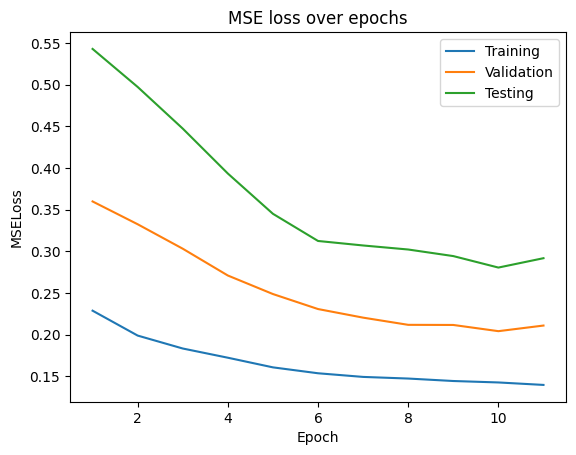

Average loss epoch 11: 0.13974918793606503
Average test loss: 0.20480947835104807
Average test loss: 0.288447448185512


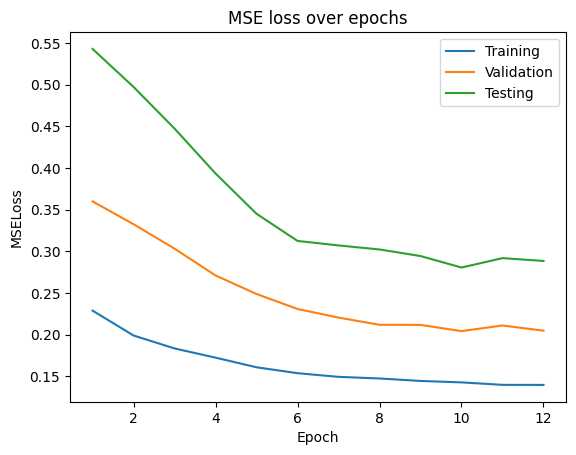

Average loss epoch 12: 0.13756001035692872
Average test loss: 0.1998398176261357
Average test loss: 0.28119772779090063


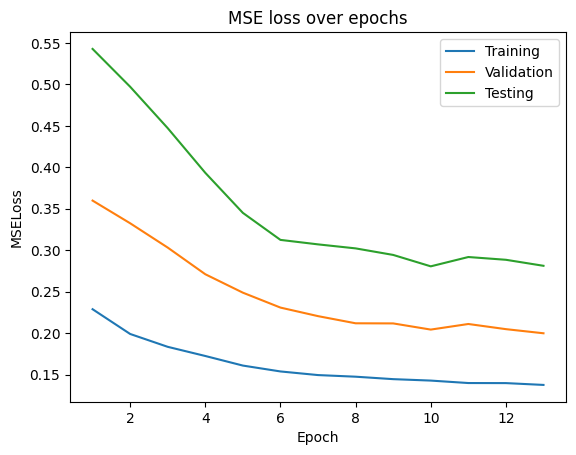

Average loss epoch 13: 0.13426428732852783
Average test loss: 0.20389904933316366
Average test loss: 0.2870319240859577


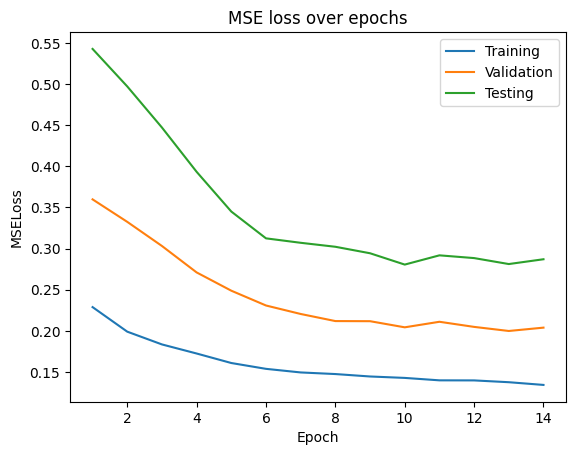

Average loss epoch 14: 0.13315834177117195
Average test loss: 0.17912490240165166
Average test loss: 0.25122907225574764


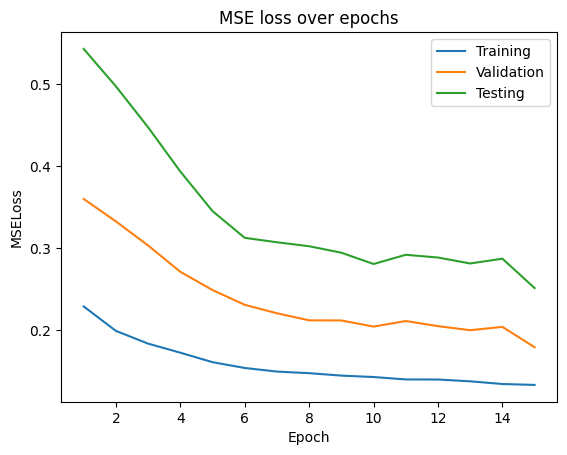

Average loss epoch 15: 0.12864900921140948
Average test loss: 0.1988033088190215
Average test loss: 0.28627086750098635


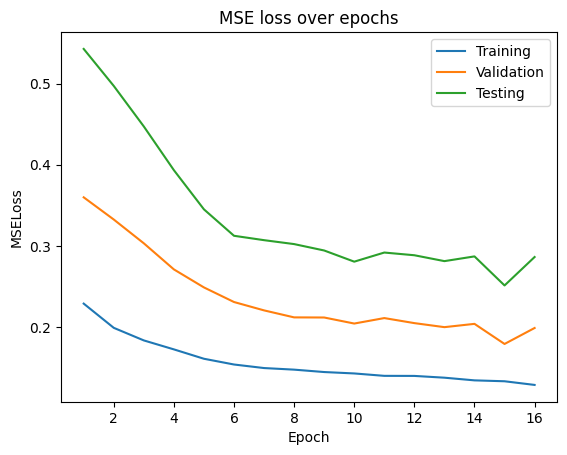

Average loss epoch 16: 0.12798186708041417
Average test loss: 0.16937495448759624
Average test loss: 0.23237287466015136


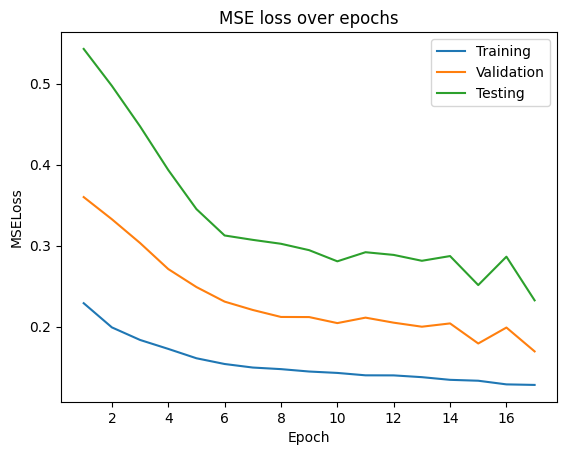

Average loss epoch 17: 0.12430967698975276
Average test loss: 0.19691133286271775
Average test loss: 0.28254614025354385


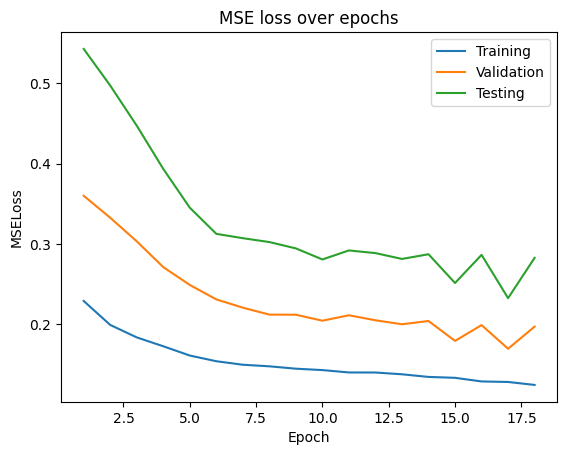

Average loss epoch 18: 0.12386127553319418
Average test loss: 0.1590894843850817
Average test loss: 0.2230577330504145


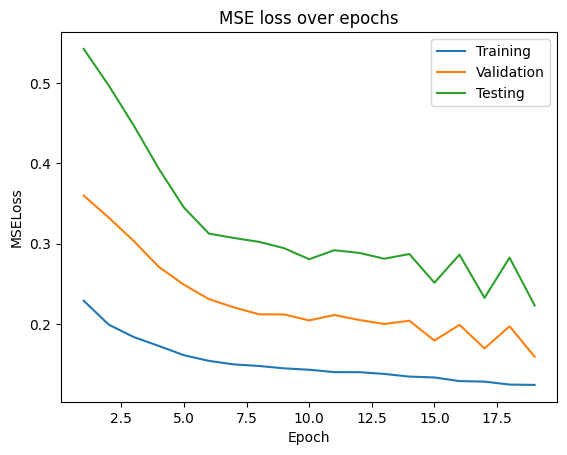

Average loss epoch 19: 0.12099303873956845
Average test loss: 0.18631589093378612
Average test loss: 0.25653270153062685


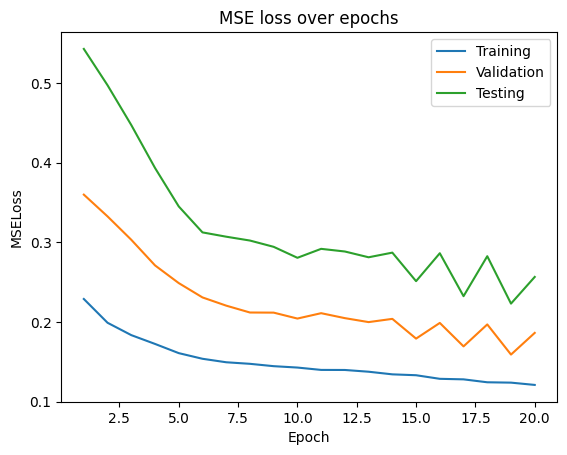

Average loss epoch 20: 0.11830455917985208
Average test loss: 0.15834976519857133
Average test loss: 0.22542093800646917


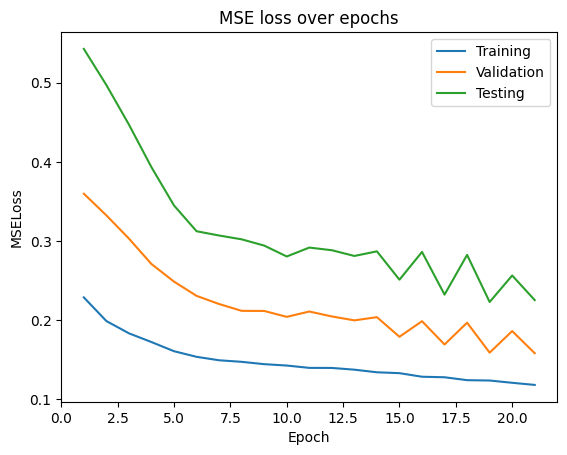

Average loss epoch 21: 0.11609225175393525
Average test loss: 0.17390366005046026
Average test loss: 0.24049104430845805


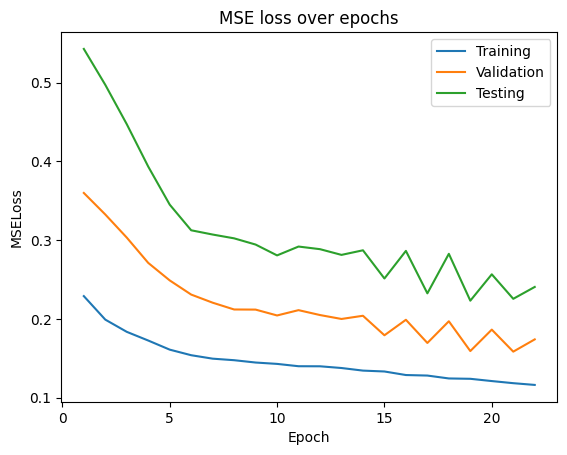

Average loss epoch 22: 0.11446039162335857
Average test loss: 0.1542276218533516
Average test loss: 0.21027827209659986


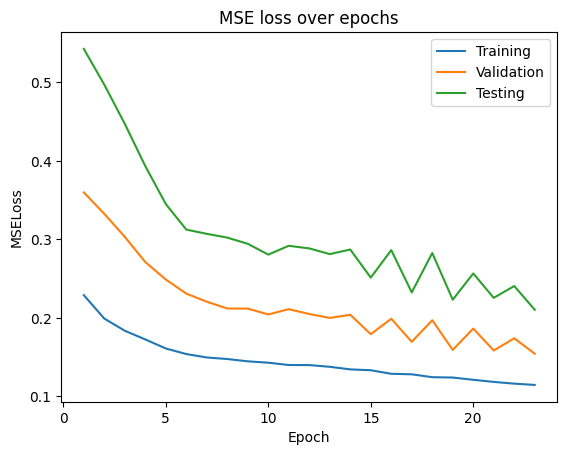

Average loss epoch 23: 0.11170529201626778
Average test loss: 0.17250337238822663
Average test loss: 0.24445536147270883


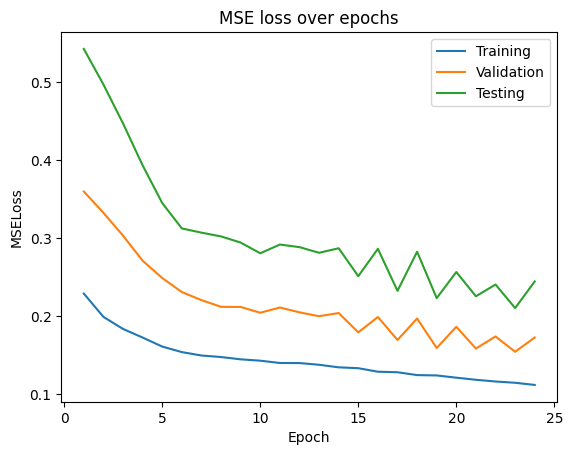

Average loss epoch 24: 0.11076369857595812
Average test loss: 0.1441188422696931
Average test loss: 0.19991312229207583


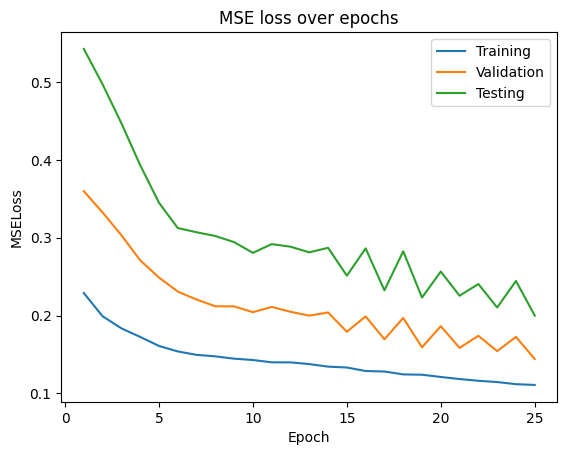

Average loss epoch 25: 0.10916053415626607
Average test loss: 0.16737768054008484
Average test loss: 0.2425979423735823


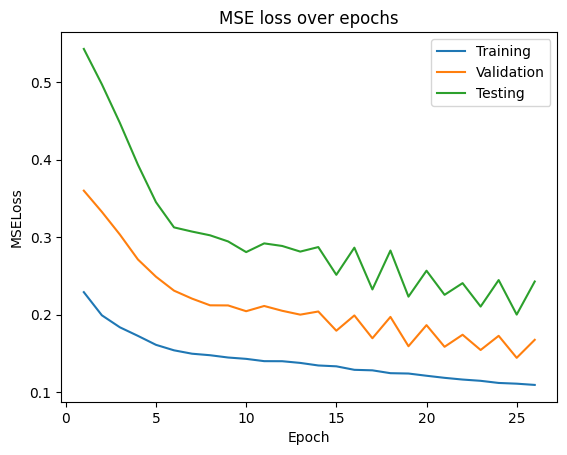

Average loss epoch 26: 0.10707358375031462
Average test loss: 0.13771913200616837
Average test loss: 0.19254610581057413


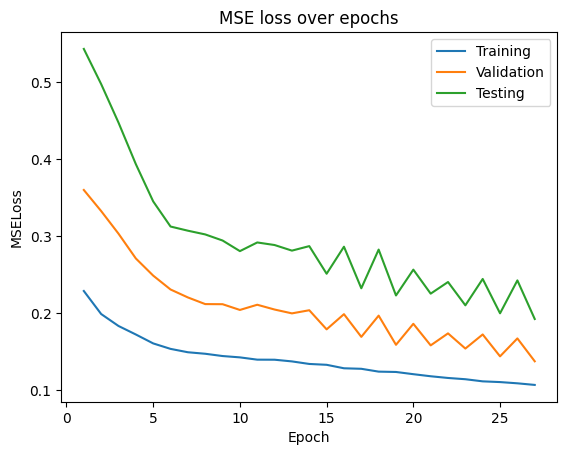

Average loss epoch 27: 0.10629866696814055
Average test loss: 0.17089797875710896
Average test loss: 0.24209736713341304


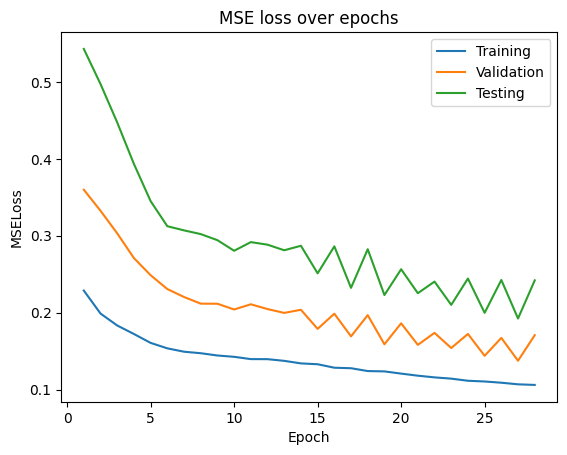

Average loss epoch 28: 0.10556289946199746
Average test loss: 0.13334813394716807
Average test loss: 0.17863584043724196


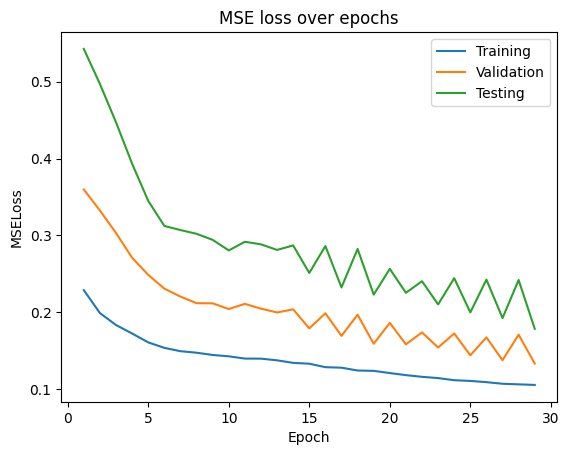

Average loss epoch 29: 0.10408639150761789
Average test loss: 0.15823694424969809
Average test loss: 0.22332827001810074


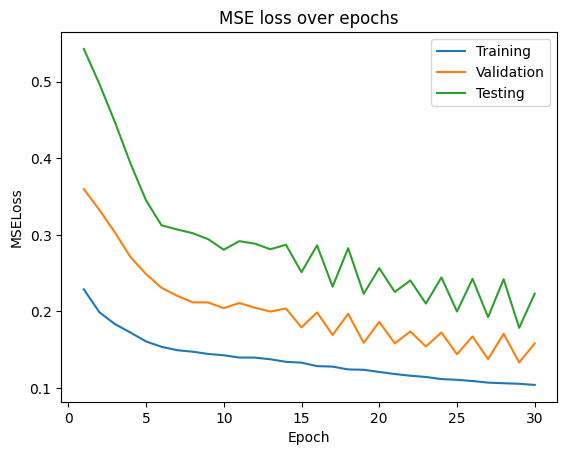

Average loss epoch 30: 0.10057189011125155
Average test loss: 0.13472151011228561
Average test loss: 0.18927095724003656


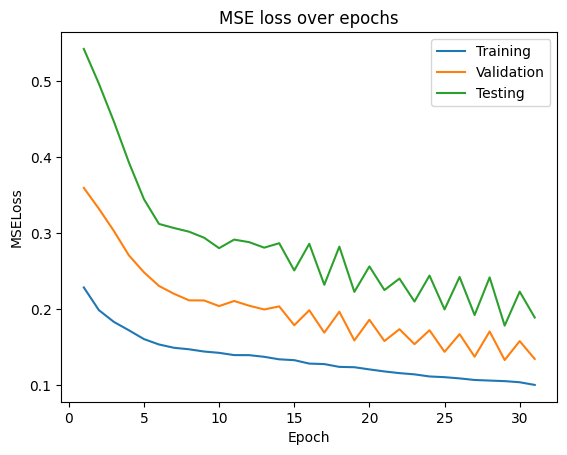

Average loss epoch 31: 0.09820807308599513
Average test loss: 0.14510127902030945
Average test loss: 0.20042828630123818


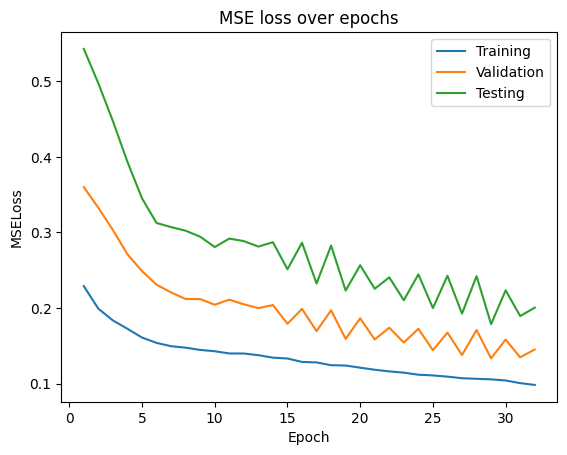

Average loss epoch 32: 0.0968223238183606
Average test loss: 0.1318414338997432
Average test loss: 0.1905022534940924


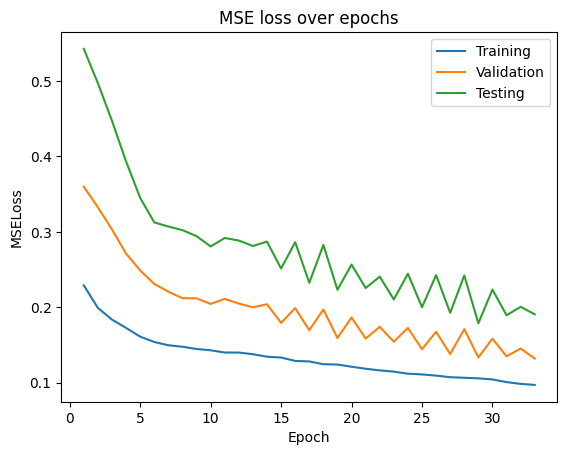

Average loss epoch 33: 0.09591981015538656
Average test loss: 0.1326091486428465
Average test loss: 0.18878819048404694


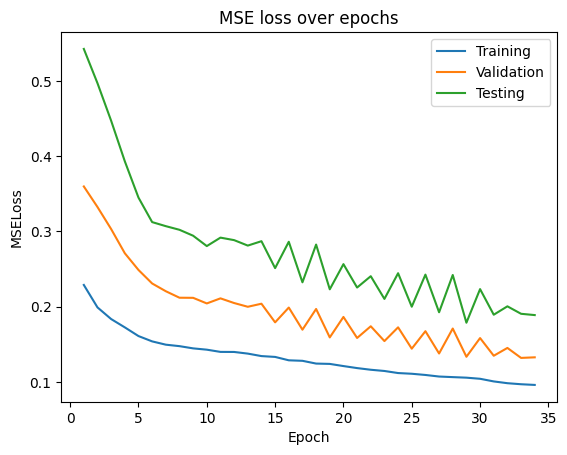

Average loss epoch 34: 0.0950377443304626
Average test loss: 0.13869259932211467
Average test loss: 0.19845421399388993


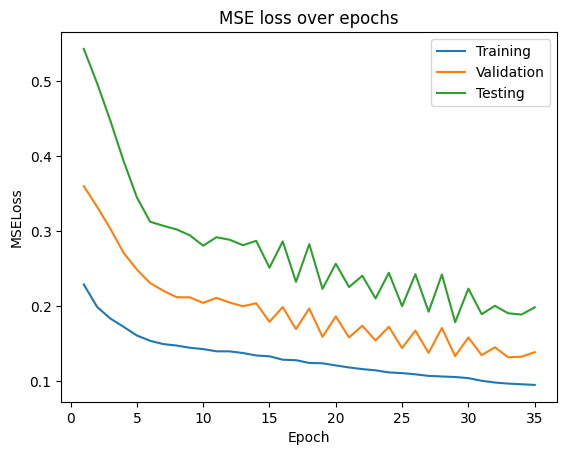

Average loss epoch 35: 0.09327857328518745
Average test loss: 0.11958121614796775
Average test loss: 0.1749326709125723


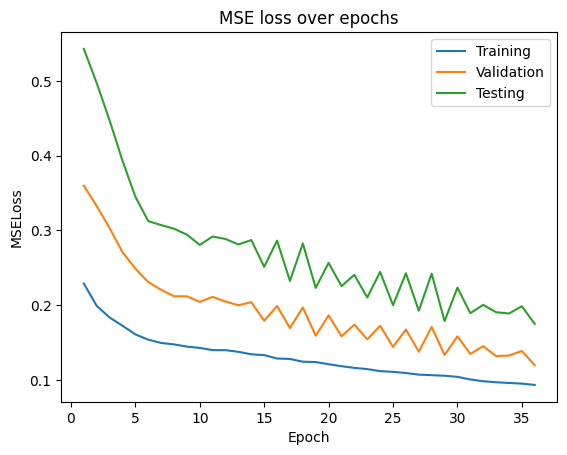

Training model: w:49, h:216
23840 1880 3600
Average loss epoch 0: 0.14561796012104197
Average test loss: 0.16832202140774047
Average test loss: 0.21339874288865499


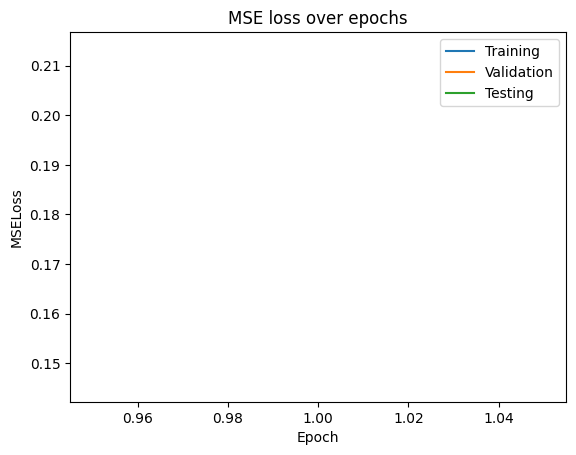

Average loss epoch 1: 0.11451379309899064
Average test loss: 0.17454265377351216
Average test loss: 0.22431530803442


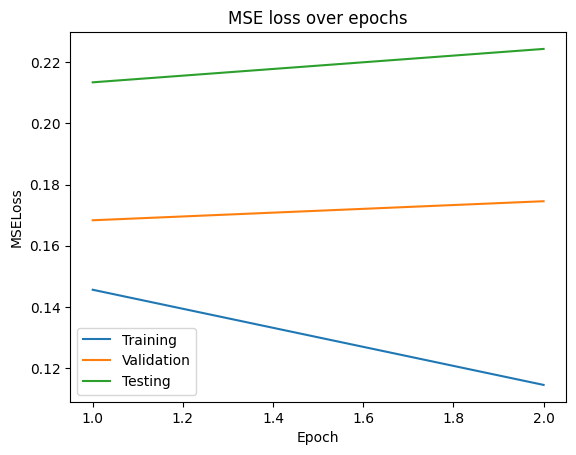

Average loss epoch 2: 0.10711386972056922
Average test loss: 0.13526139195476258
Average test loss: 0.17003119311162404


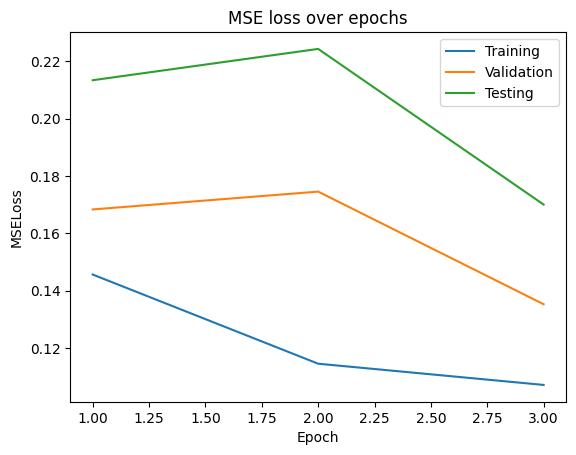

Average loss epoch 3: 0.10658393828298456
Average test loss: 0.20827089143650873
Average test loss: 0.29625542142561506


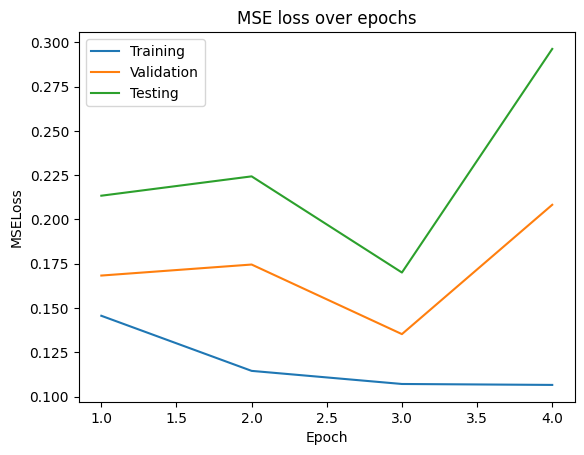

Average loss epoch 4: 0.11047477166979544
Average test loss: 0.12001049837895802
Average test loss: 0.1498601090695177


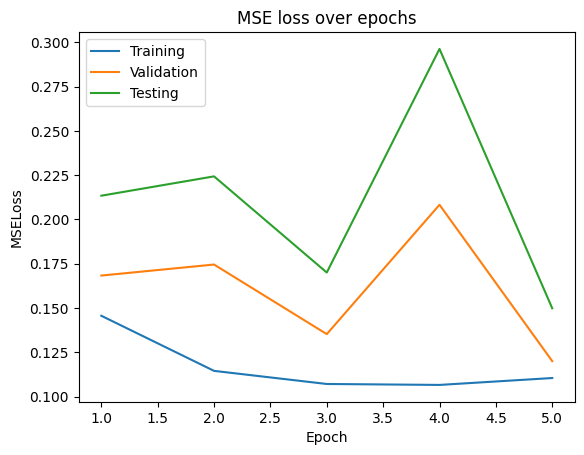

Average loss epoch 5: 0.10670396661566149
Average test loss: 0.1843099860208375
Average test loss: 0.25876102277210783


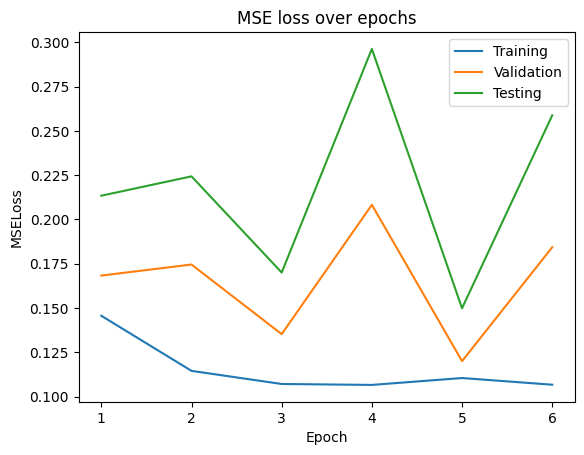

Average loss epoch 6: 0.10456640473617021
Average test loss: 0.12940809024231775
Average test loss: 0.16045451323900903


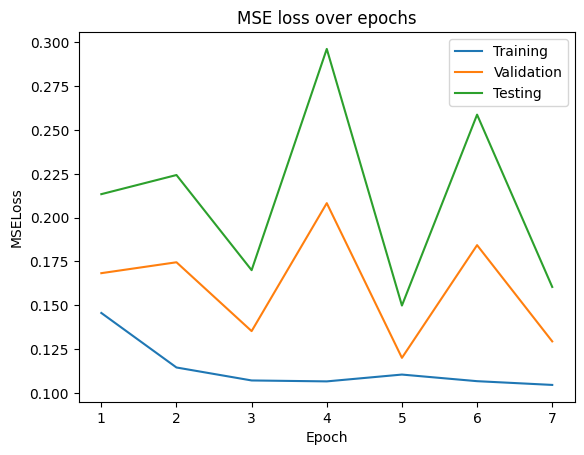

Average loss epoch 7: 0.09887706780786155
Average test loss: 0.1591080746480397
Average test loss: 0.20577507040330342


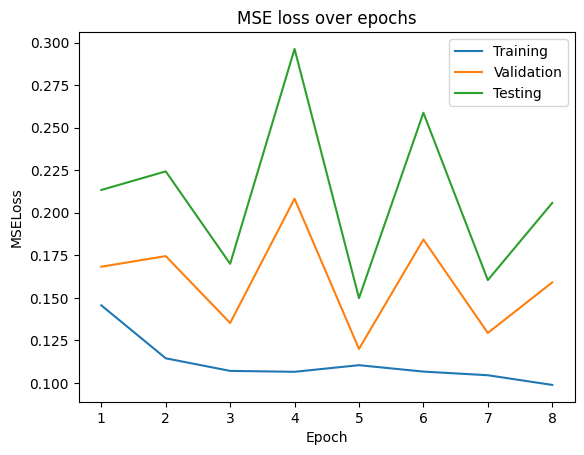

Average loss epoch 8: 0.09725571179421999
Average test loss: 0.12538578254835947
Average test loss: 0.1504649966955185


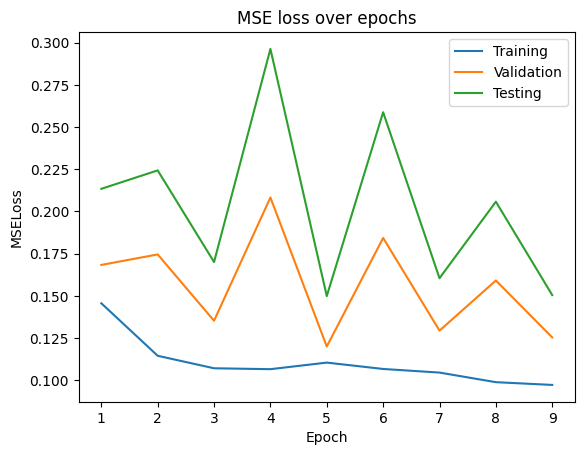

Average loss epoch 9: 0.0943772750355864
Average test loss: 0.15707141160964966
Average test loss: 0.20287780463695526


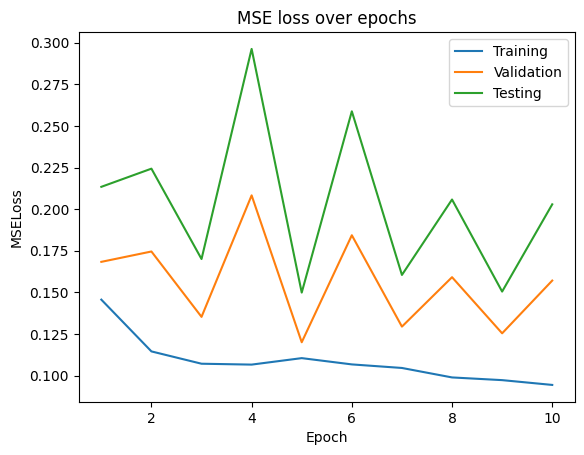

Average loss epoch 10: 0.09399800579394063
Average test loss: 0.10906688390033585
Average test loss: 0.13429853107248033


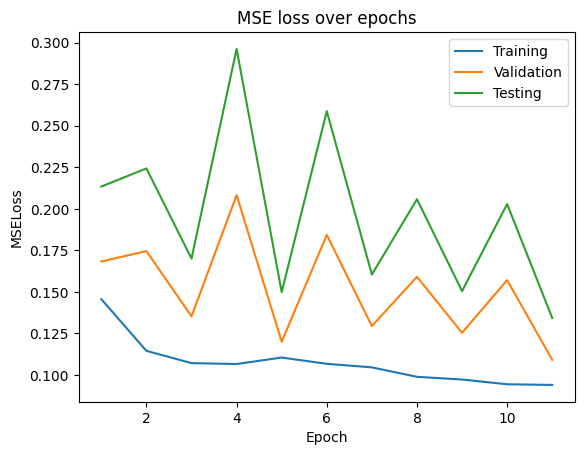

Average loss epoch 11: 0.09345280146726997
Average test loss: 0.17227353581360408
Average test loss: 0.22883710903780802


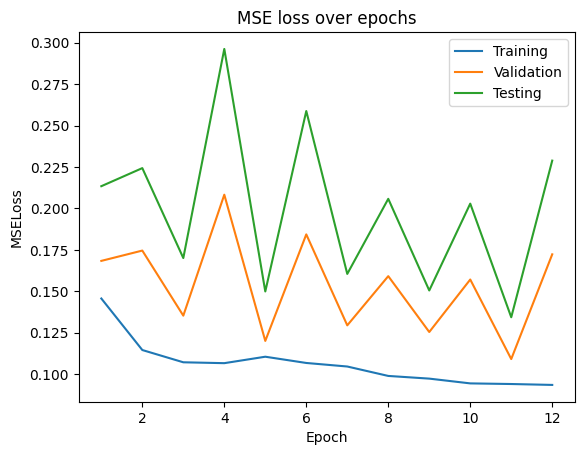

Average loss epoch 12: 0.09462086632046648
Average test loss: 0.10335702342646462
Average test loss: 0.12187222896942071


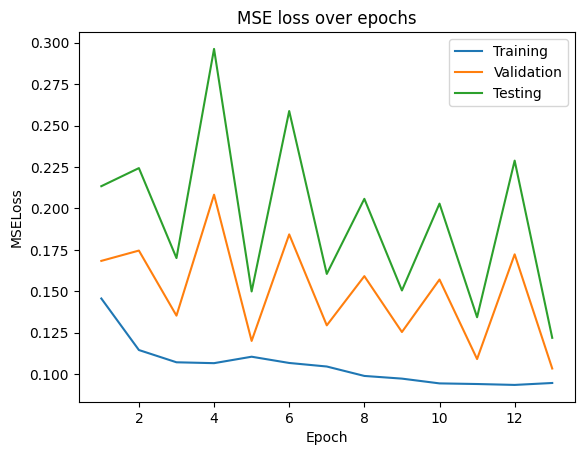

Average loss epoch 13: 0.09414018117772635
Average test loss: 0.16988665078367507
Average test loss: 0.22813805512019567


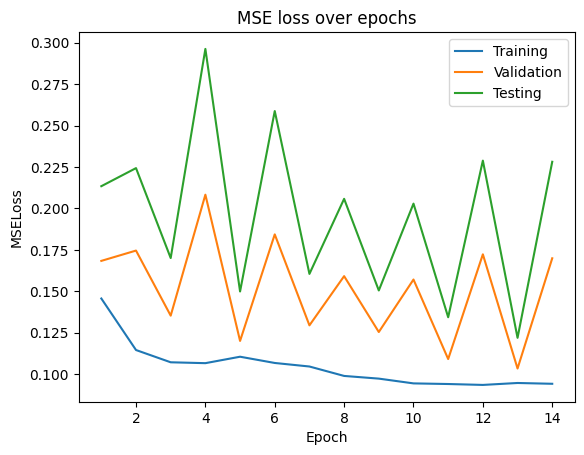

Average loss epoch 14: 0.09314154348866914
Average test loss: 0.09909995698503085
Average test loss: 0.11943716023649488


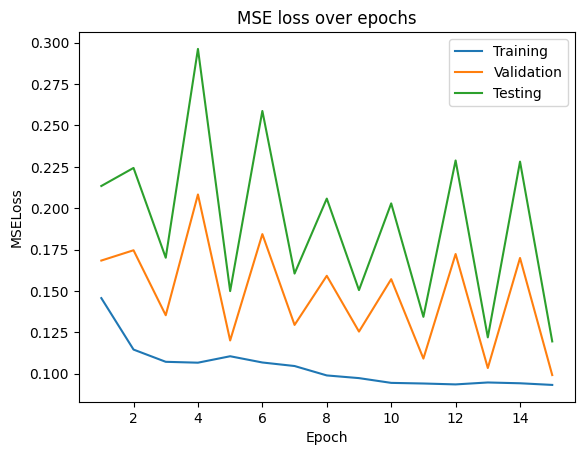

Average loss epoch 15: 0.08743486869879948
Average test loss: 0.1375205942562648
Average test loss: 0.17861968172448023


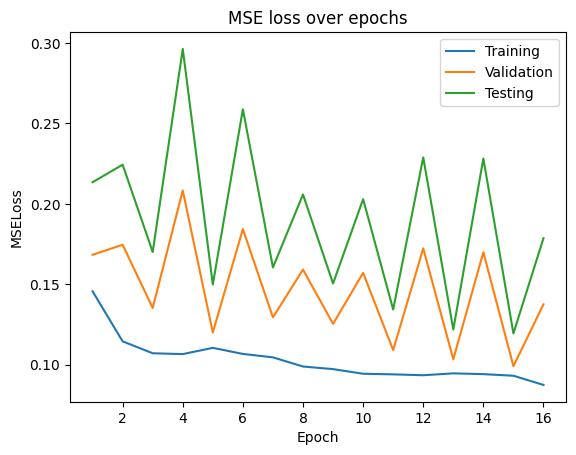

Average loss epoch 16: 0.08564782006445751
Average test loss: 0.09660100883671216
Average test loss: 0.11457807118339199


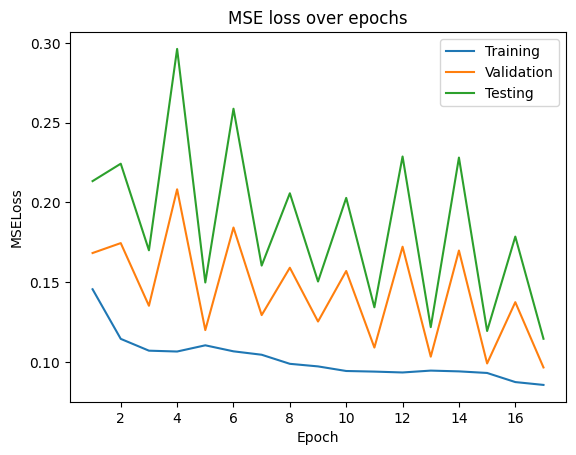

Average loss epoch 17: 0.08354408590383428
Average test loss: 0.1305333450436592
Average test loss: 0.16853937719549453


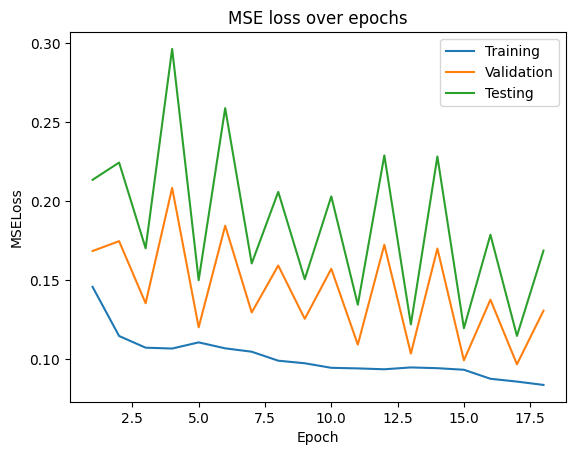

Average loss epoch 18: 0.08233337228496869
Average test loss: 0.09176738719855036
Average test loss: 0.10916690794484955


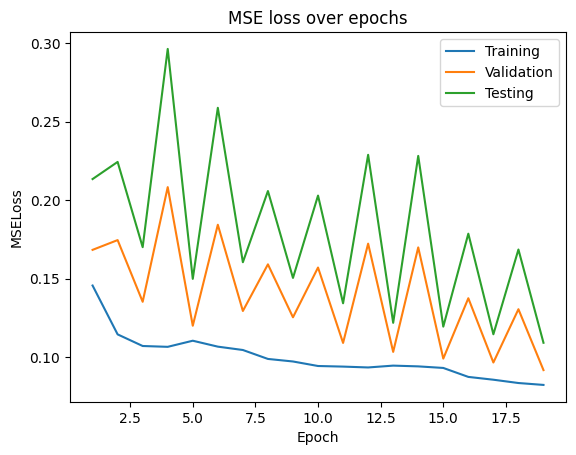

Average loss epoch 19: 0.08182070712729167
Average test loss: 0.1309933534690312
Average test loss: 0.17404507685984885


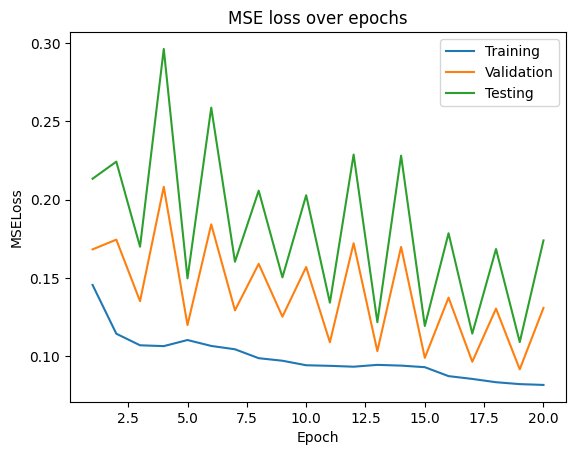

Average loss epoch 20: 0.08087811687140055
Average test loss: 0.08196835592389107
Average test loss: 0.09437211656144687


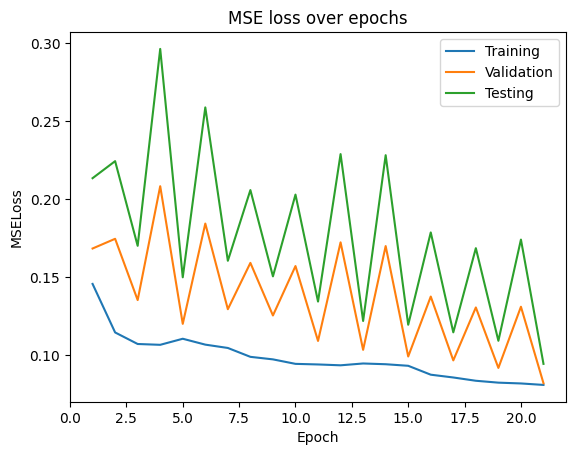

Average loss epoch 21: 0.08062454397159238
Average test loss: 0.13550968148878642
Average test loss: 0.1884848943778447


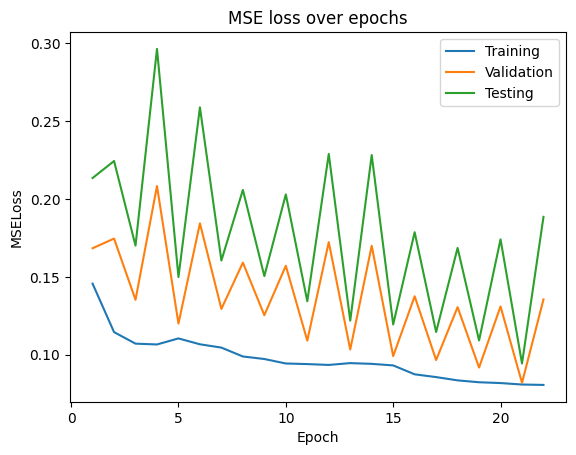

Average loss epoch 22: 0.08013032264606927
Average test loss: 0.07254520377942494
Average test loss: 0.08184894333992686


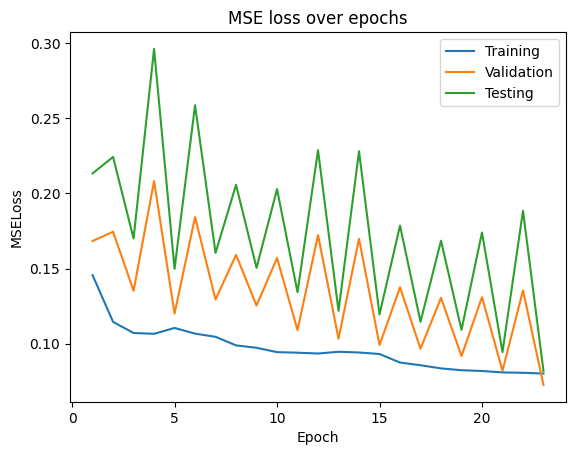

Average loss epoch 23: 0.07796117314888586
Average test loss: 0.1331913811819894
Average test loss: 0.18095109292439052


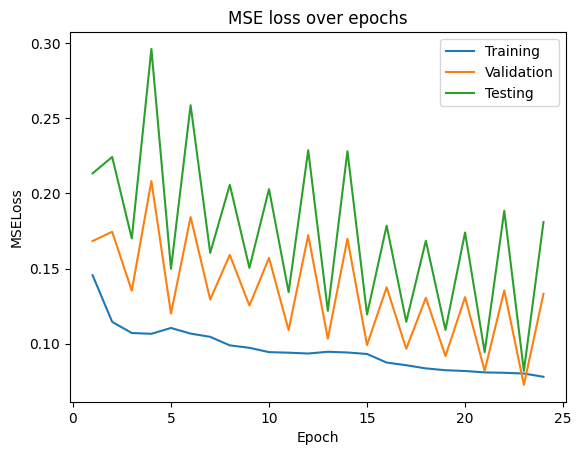

Average loss epoch 24: 0.07686188788984412
Average test loss: 0.0736573189496994
Average test loss: 0.08423510965492044


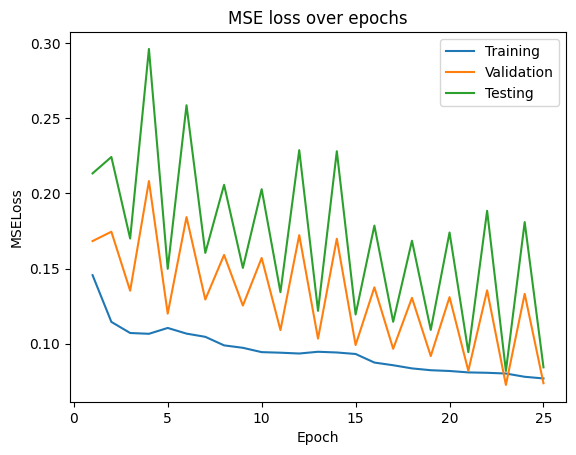

Average loss epoch 25: 0.07447986156549505
Average test loss: 0.11598011212689537
Average test loss: 0.1589010144983019


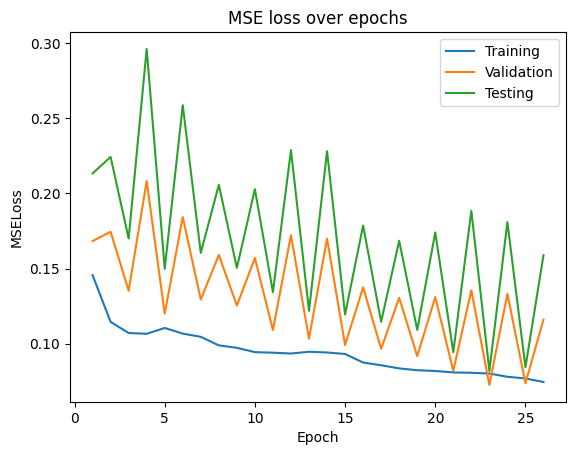

Average loss epoch 26: 0.07233186418651252
Average test loss: 0.07341948098370008
Average test loss: 0.08682627922722272


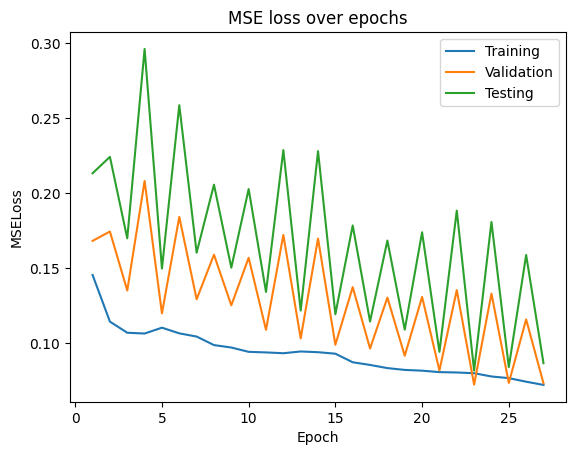

Average loss epoch 27: 0.07128151081582551
Average test loss: 0.10829015714781624
Average test loss: 0.14158459539924348


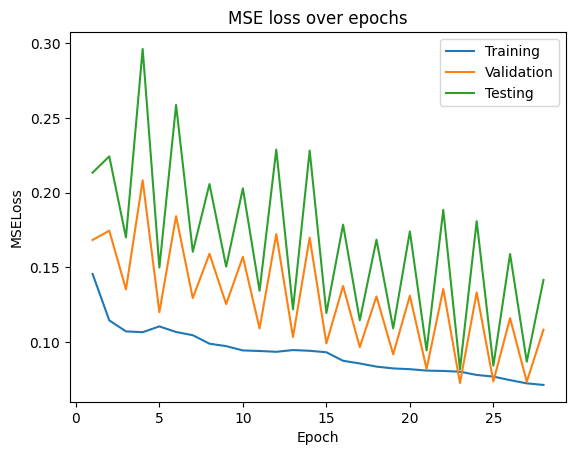

Average loss epoch 28: 0.06937894381342395
Average test loss: 0.07096390905124801
Average test loss: 0.0851530201200928


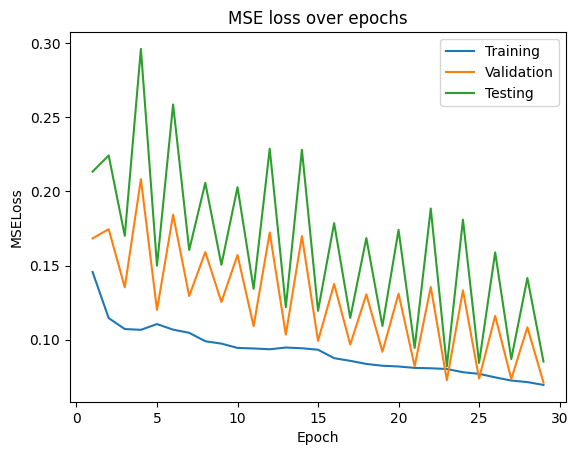

Average loss epoch 29: 0.06903196368566765
Average test loss: 0.11064909185682024
Average test loss: 0.1497122836964471


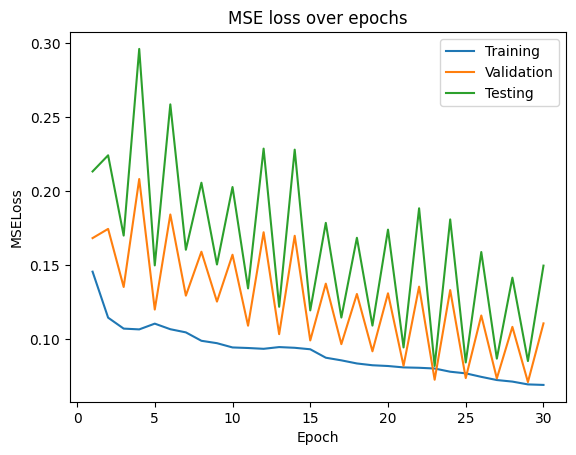

Average loss epoch 30: 0.06896636172408058
Average test loss: 0.06573368342859405
Average test loss: 0.07828879462821144


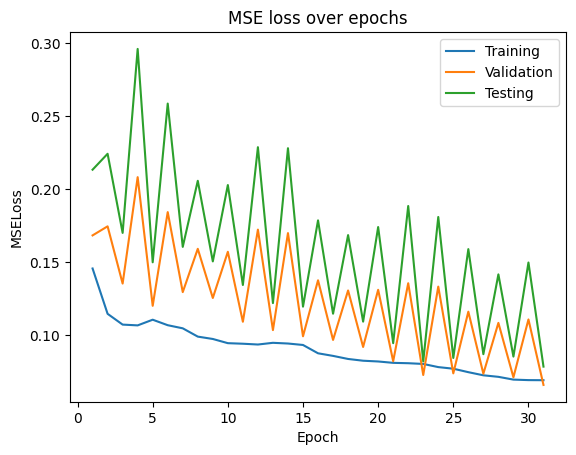

Average loss epoch 31: 0.06873384881163797
Average test loss: 0.11316785003457751
Average test loss: 0.15756115476999963


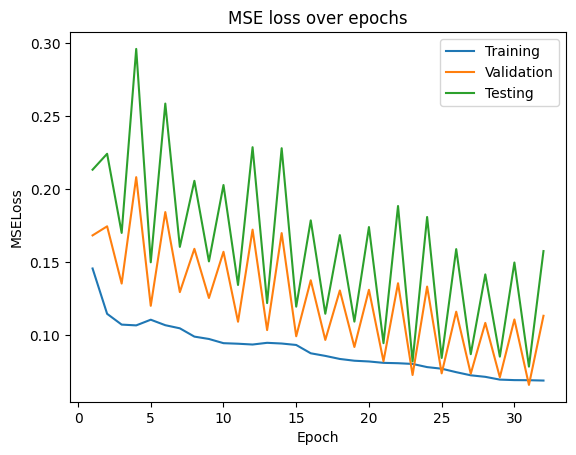

Average loss epoch 32: 0.0689487088151196
Average test loss: 0.06639229186943599
Average test loss: 0.07884839682706765


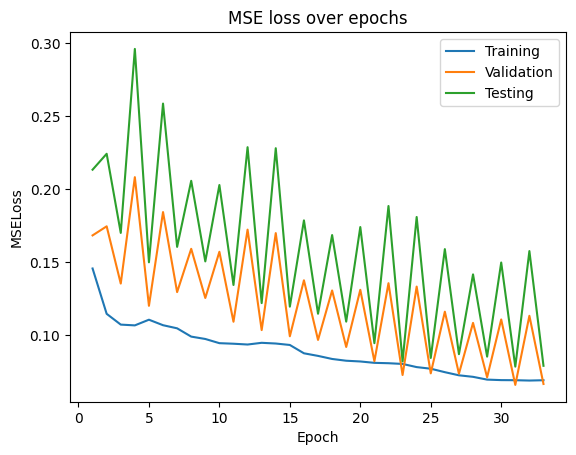

Average loss epoch 33: 0.06694046353861209
Average test loss: 0.10363463738134929
Average test loss: 0.14531485523496354


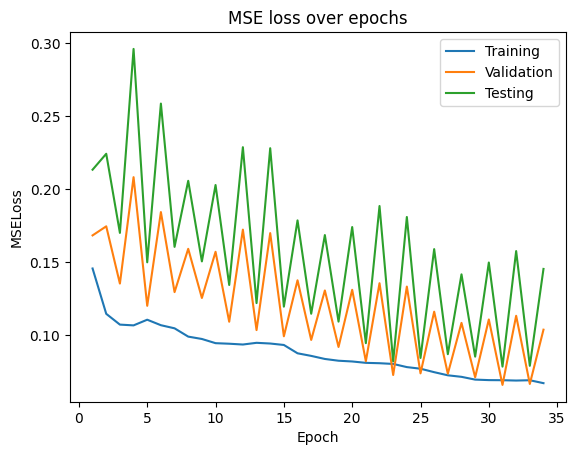

Average loss epoch 34: 0.0646482045131345
Average test loss: 0.06540938520005771
Average test loss: 0.07643690971391541


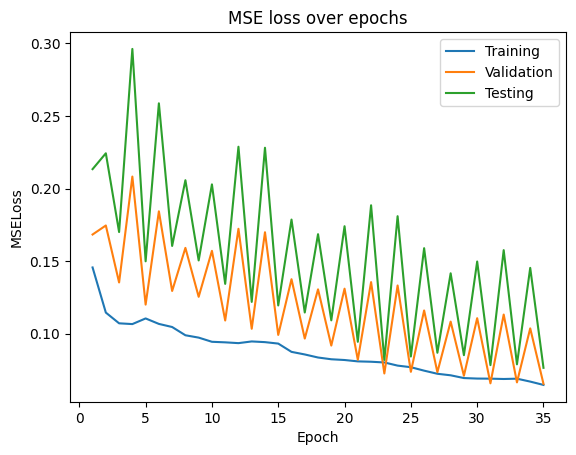

Average loss epoch 35: 0.06306974273375286
Average test loss: 0.09784963620560509
Average test loss: 0.13357707538775035


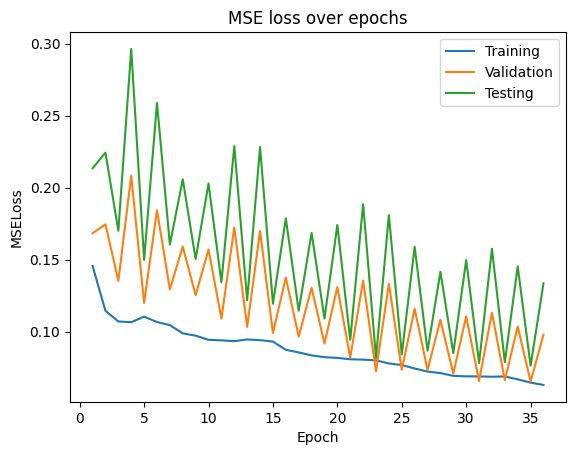

In [12]:
trainp = "/Users/jakecordery/Desktop/dissertation-york/data/processed/GCN/train_graphs" 
valp = "/Users/jakecordery/Desktop/dissertation-york/data/processed/GCN/val_graphs" 
testp = "/Users/jakecordery/Desktop/dissertation-york/data/processed/GCN/test_graphs"

trainp = "/Users/jakecordery/Desktop/dissertation-york/notebooks/data/processed/step1_train_graphs" 
valp = "/Users/jakecordery/Desktop/dissertation-york/notebooks/data/processed/step1_val_graphs" 
testp = "/Users/jakecordery/Desktop/dissertation-york/data/processed/GCN/test_graphs"

#for w, h in zip([28, 35, 42, 49], [128, 256, 128, 216]):
for w, h in zip([42, 49], [128, 216]):
    print(f"Training model: w:{w}, h:{h}")
    trainds = GraphDataset(path=trainp, dates=train_dates, window_size=w)
    valds = GraphDataset(path=valp, dates=val_dates, window_size=w)
    testds = GraphDataset(path=testp, dates=test_dates, window_size=w)

    print(len(trainds), len(valds), len(testds))

    bs = 128
    model = GCN1(in_size=w-7, hidden=h).to(CFG.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    spath = "gweights/GCN1"
    train(model, optimizer, dataset=trainds, valds=valds, testds=testds, bs=bs, spath=spath)